# Benchmark test to evaluate different thresholder performance

### The following is a collection of tests that can be used to evaluate different aspects of a thresholders performance with respect to the MCC score. This can be substituted for the F1 score or any other applicable score.

The tests covered in this example include:

1. **Unit-normalized MCC score for a single OD likelihood and thresholder/s** 
2. **Unit-normalized MCC score for multiple OD likelihoods and thresholder/s**
3. **Comparison between the performance of thresholders with respect to single or multiple OD likelihood/s input**
4. **Overprediction with respect to the contamination**
5. **Overprediction with respect to the best unit-normalized MCC score**
6. **Effects of randmoness on thresholders**
7. **Thresholder time complexity performance**

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
import warnings
from time import time

import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from numpy import percentile
from pyod.utils.utility import standardizer
from pythresh.thresholds.thresh_utility import cut, normalize
from scipy.io import loadmat
from scipy.optimize import basinhopping
from sklearn.metrics import matthews_corrcoef
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings("ignore")

# Define data file and read X and y
mat_file_list = ['arrhythmia.mat',
                 'cardio.mat',
                 'glass.mat',
                 'ionosphere.mat',
                 'letter.mat',
                 'lympho.mat',
                 'mnist.mat',
                 'musk.mat',
                 'optdigits.mat',
                 'pendigits.mat',
                 'pima.mat',
                 'satellite.mat',
                 'satimage-2.mat',
                 'vertebral.mat',
                 'vowels.mat',
                 'wbc.mat']

random_state = np.random.RandomState(1234)

### 1. Define Benchmark and Plotting Functions

In [2]:
def negative_mcc_threshold(threshold, scores, y):
    '''Caculate the coresponding MCC score'''
    
    labels = cut(scores, threshold)
    return -(matthews_corrcoef(y, labels) + 1)

def benchmark(od_models, thresh_models, method='single', compare=False, 
              overpred=[False, False], verbose=False):
    '''MCC benchmarking function with multi-options for different tests

       Parameters
       ----------

       od_models : list
            List of one or many uninitialized outlier detection models
            e.g. [KNN, GMM]

       thresh_models : list
            List of one or many initialized thresholders
            e.g. [DSN(), CLF()]

       method : str, optional (default='single')
            Use 'single' to evaluate each OD methods individually,
            Use 'multiple' to evaluate the 1D array of decomposed decision scores
            from the list of OD methods

       compare : bool, optional (default=False)
            Return back the single and multiple comparison methods by evaluating
            the method against the true labels instead of the contamination labels.
            To compare this must be run for both 'single' and 'multiple' individually

       overpred : list, optional (default=[False, False])
            List of two bools that test for overprediction, the first bool is to 
            activate the overpred flag the second is to use the best MCC score to
            compare to instead of the contamination labels.

       verbose : bool, optional (default=False)
    
    '''

    df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc']
    df_columns.extend([thr.__class__.__name__ for thr in thresh_models])

    df = pd.DataFrame(columns=df_columns)

    models = od_models if method=='single' else [1]
    
    for cl in models:
        for mat_file in mat_file_list:
            
            if verbose:
                print("\n... Processing", mat_file, '...')
                
            mat = loadmat(os.path.join('data', mat_file))
    
            X = mat['X']
            y = mat['y'].ravel()
            outliers_fraction = np.count_nonzero(y) / len(y)
            outliers_percentage = round(outliers_fraction * 100, ndigits=4)

            # construct containers for saving results
            df_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    
            X_norm = standardizer(X)

            # Apply outlier detection
            if method=='single':
            
                try:
                    clf = cl(contamination=outliers_fraction, random_state=1234)
                    
                except:
                    clf = cl(contamination=outliers_fraction)
                clf.fit(X_norm)
                scores = normalize(clf.decision_scores_)
                labels = clf.labels_

            # Apply multi outlier detection
            else:

                scores = []
                for od_mod in od_models:
                    try:
                        clf = od_mod(contamination=outliers_fraction, random_state=1234)
        
                    except:
                        clf = od_mod(contamination=outliers_fraction)
                    clf.fit(X_norm)
                    scores.append(clf.decision_scores_)
                
                scores = np.vstack(scores).T
                
                decomp = TruncatedSVD(n_components=1, random_state=1234)
        
                decision = decomp.fit_transform(normalize(scores)).squeeze()
                scores = normalize(decision)
                
                thresh_ = np.percentile(decision, 100 * (1 - outliers_fraction))
                labels = (decision > thresh_).astype('int').ravel()
    
            # Compute each thresholder
            for thres in thresh_models:
                pred = thres.eval(scores)

                if compare:
                    labels = y

                if not overpred[0]:
                    df_list.append(round((matthews_corrcoef(y,pred)+1) - 
                                     (matthews_corrcoef(y,labels)+1), ndigits=4))

                else:

                    # Find threshold with best MCC
                    if overpred[1]:

                        minimizer_kwargs = {'method': 'L-BFGS-B', 'args': (scores, y),
                                            'bounds': [(np.median(scores), np.max(scores))]}

                        result = basinhopping(negative_mcc_threshold,
                                               x0=np.mean(scores) + np.std(scores),
                                               minimizer_kwargs=minimizer_kwargs,
                                               T=1, stepsize=np.var(scores), seed=1234)
                        
                        best_thresh = result.x
                        labels = cut(scores, best_thresh)

                    df_list.append(round(np.sum(pred)/np.sum(labels), ndigits=4))

            temp_df = pd.DataFrame(df_list).transpose()
            temp_df.columns = df_columns
            df = pd.concat([df, temp_df], axis=0)

    return df


In [3]:
def bench_plotter(df, random=False):
    '''Standard benchmark plotting function

       Parameters
       ----------

       df : benchmarked dataframe

       random : bool, optional (default=False)
            Whether to plot the effects of randomness (duplicate 
            thresholders evaluated for different random states must be provided 
            in the input dataframe)
    '''
    
    thres = df.columns[4:]

    if random:

        column_counts = df.columns.value_counts()
        common_prefixes = column_counts[column_counts > 1].index

        # Iterate through the identified common prefixes
        for prefix in common_prefixes:

            columns_with_prefix = [col for col in df.columns if col.startswith(prefix)]
            
            reps = df[columns_with_prefix] * 0.5
            randomness = reps.std(axis=1)
            
            df.drop(columns=columns_with_prefix, inplace=True)
            df[prefix] = randomness
    
    fig = plt.figure(figsize=(14,8))
    ls = []
    
    for col in thres:
    
        ls.append(np.nanmean(df[col]))
    
    
    idx = np.argsort(ls)
    
    thres = thres[idx[::-1]]
    
    j = 0
    for i, col in enumerate(thres):

        # unit-normalized MCC = (MCC + 1)/2   
        if not random:
            plt.errorbar([col], [np.nanmean(0.5*df[col])],
                         yerr=[np.nanstd(0.5*df[col])],
                         fmt='o', capsize=5, label=col)

        else:
            plt.errorbar([col], [0],
                         yerr=[np.nanmean(df[col])],
                         fmt='o', capsize=5, label=col)
        
        # Other optional plotting methods for default benchmarks
        #plt.scatter([col]*len(df[col]), 0.5*df[col], s=1, alpha=0)
        #plt.violinplot(0.5*df[col], positions=[i], showmeans=True)
        #plt.boxplot(0.5*df[col], positions=[i])
        #plt.scatter([col], [np.nanmean(0.5*df[col])], s=80)
        j += 1
    
    
    plt.xticks(rotation='vertical', weight = 'bold')
    plt.margins(x=0.012)
    plt.tight_layout(pad=1.5)
    plt.show()


In [4]:
def plotter_sing_mult(df_single, df_mult):
    '''Plotting function to compare single vs multiple OD

       Parameters
       ----------

       df : single benchmark OD dataframe

       df_mult : multiple benchmark OD dataframe
    '''
    
    thres_single = df_single.columns[4:]
    thres_mult = df_mult.columns[4:]
    
    fig = plt.figure(figsize=(14,8))
    ls = []
    
    for col in thres_mult:
    
        ls.append(np.nanmean(df_mult[col]))
    
    
    idx = np.argsort(ls)
    thres = thres_mult[idx[::-1]]

    j = 0
    for i, col in enumerate(thres):
    
        # Create vertical dumbbel plots
        ratio = ((np.nanmean(0.5*df_mult[col])-np.nanmean(0.5*df_single[col]))/abs(np.nanmean(0.5*df_mult[col])))
        mi = min(np.nanmean(0.5*df_mult[col]), np.nanmean(0.5*df_single[col])) + 0.0001 + 0.3
        ma = max(np.nanmean(0.5*df_mult[col]), np.nanmean(0.5*df_single[col])) - 0.0001 + 0.3
    
        plt.vlines([col], [mi], [ma], colors='gray', linewidth=1.5)
        plt.scatter([col], [np.nanmean(0.5*df_mult[col])+0.3], c='b', s=30)
        plt.scatter([col], [np.nanmean(0.5*df_single[col])+0.3], c='r', s=30)
    
        plt.annotate(f'{round(ratio*100, 1)}%', (j,ma), textcoords="offset points",
                     xytext=(4,8), fontsize=8, ha='center', fontweight='bold')
        
        j += 1
    
    color_patch1 = mpatches.Patch(color='red', label='Single')
    color_patch2 = mpatches.Patch(color='blue', label='Multiple')
    plt.legend(handles=[color_patch1, color_patch2])
    
    plt.xticks(rotation='vertical', weight = 'bold')
    plt.margins(x=0.012)
    plt.tight_layout(pad=1.5)
    plt.show()


In [5]:
def plotter_overpred(df):
    '''Plotting function for overprediction

       Parameters
       ----------

       df : benchmarked dataframe
    '''
    
    thres = df.columns[4:]
    
    fig = plt.figure(figsize=(14,8))
    ls = []
    
    for col in thres:
    
        val = df[col].values
        val[val==0] = 1e-40
        ls.append(np.mean(val-1))
    
    
    idx = np.argsort(ls)
    
    thres = thres[idx[::-1]]
    
    for i, col in enumerate(thres):
    
        val = df[col].values
        val[val==0] = 1e-40
    
        hstd = stats.sem(val-1)
        plt.bar([col], [np.mean(val-1)], yerr=hstd, capsize=3,
                label=col)
    
    plt.xticks(rotation='vertical')
    plt.margins(x=0.015)
    plt.tight_layout()
    plt.show()
    

### 2. Benchmark Function Calls

In [14]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.hbos import HBOS
from pyod.models.kde import KDE
from pyod.models.gmm import GMM
from pyod.models.copod import COPOD

from pythresh.thresholds.iqr import IQR
from pythresh.thresholds.mad import MAD
from pythresh.thresholds.fwfm import FWFM
from pythresh.thresholds.yj import YJ
from pythresh.thresholds.ocsvm import OCSVM
from pythresh.thresholds.regr import REGR

clfs = [KNN, GMM]
thres = [IQR(), MAD()]

# Apply single standrd benchmark
df = benchmark(clfs, thres, method='single')

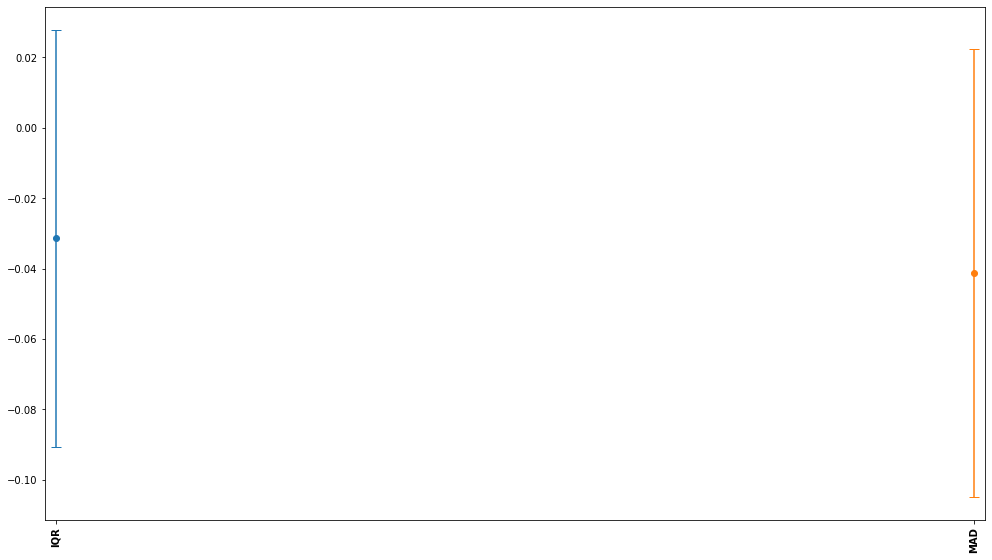

In [15]:
bench_plotter(df)

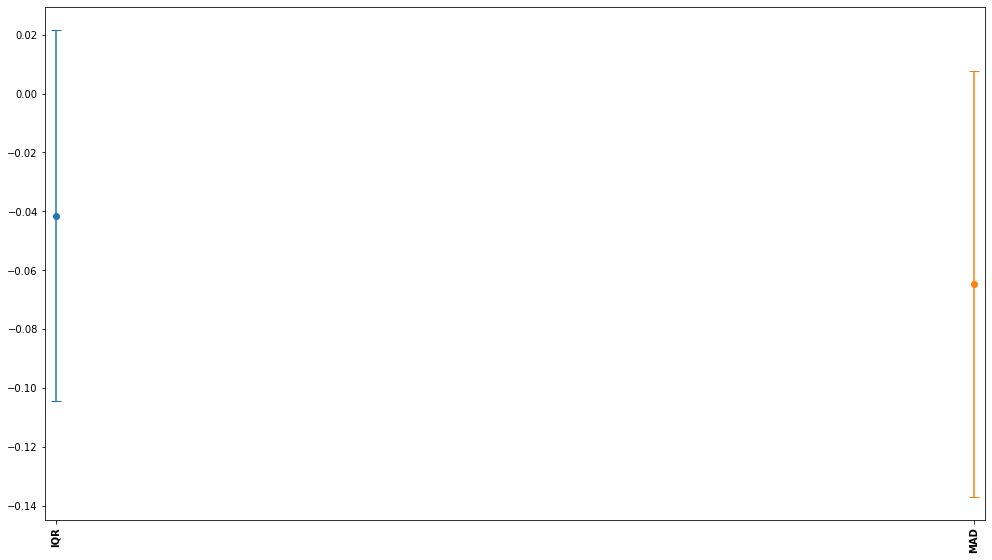

In [16]:
# Apply multiple standard benchmark
df = benchmark(clfs, thres, method='multiple')
bench_plotter(df)

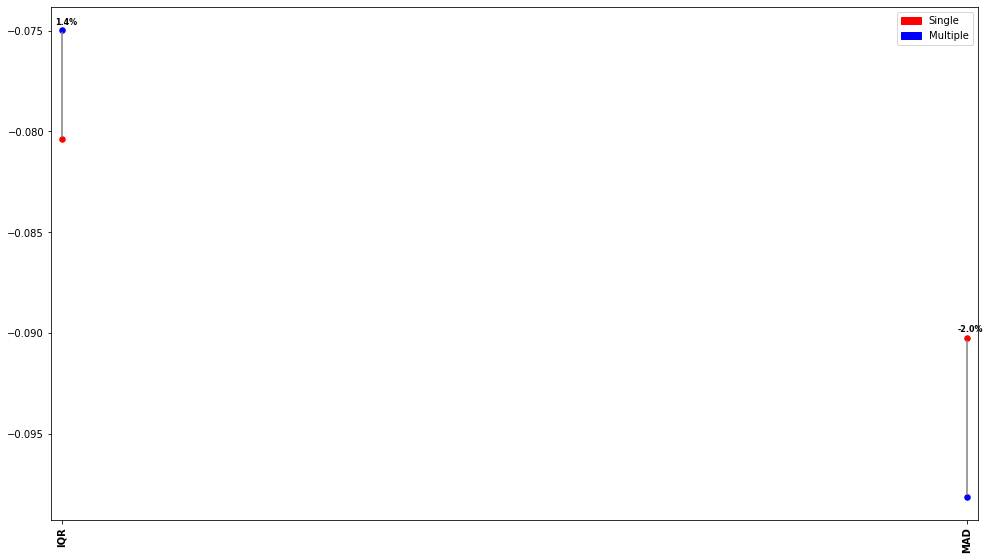

In [8]:
# Apply compare benchmark between single and multiple
df_single = benchmark(clfs, thres, method='single', compare=True)
df_mult = benchmark(clfs, thres, method='multiple', compare=True)
plotter_sing_mult(df_single, df_mult)

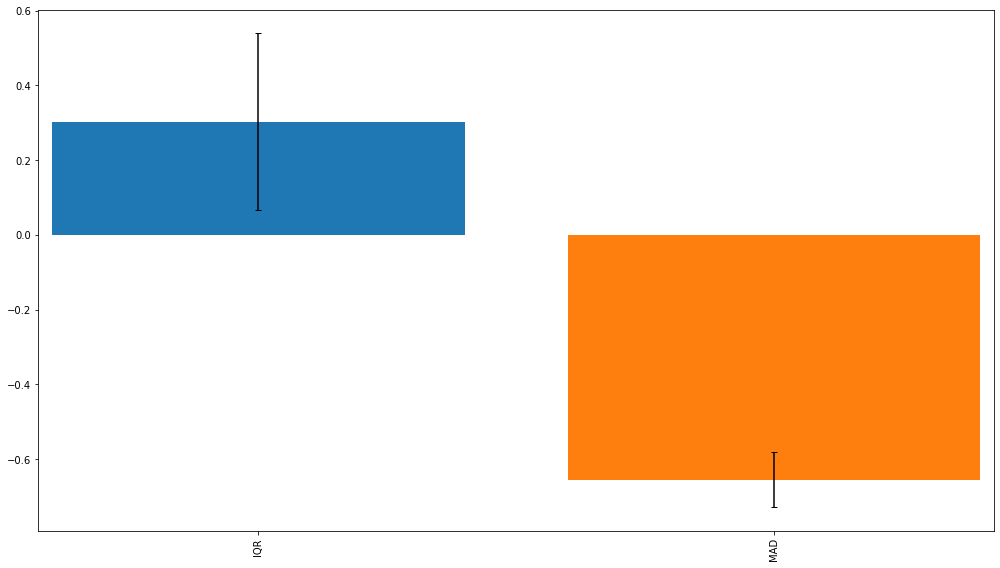

In [9]:
# Apply overprediction benchmark
df = benchmark(clfs, thres, method='single', overpred=[True, False])
plotter_overpred(df)

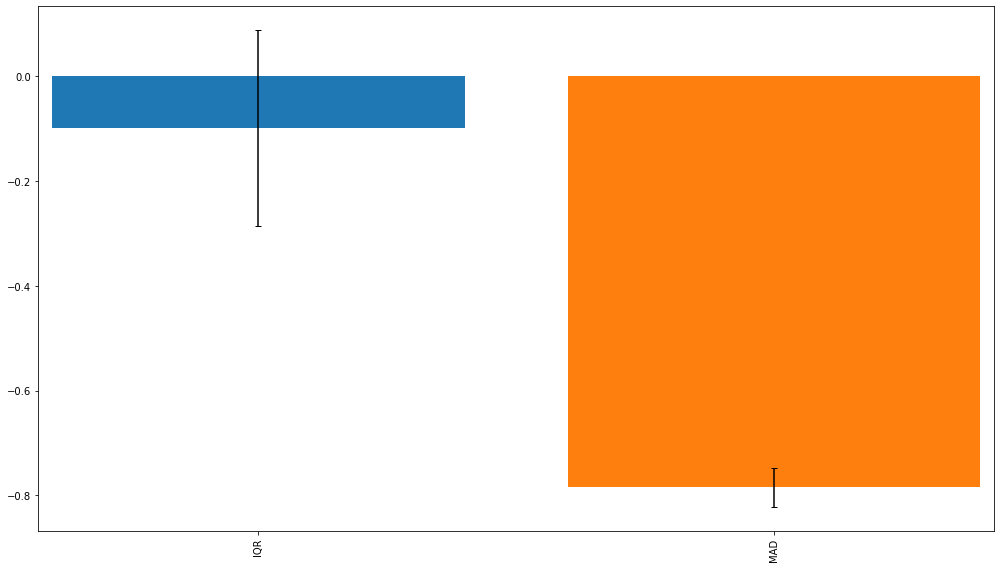

In [10]:
# Apply overprediction benchmark against best MCC
df = benchmark(clfs, thres, method='single', overpred=[True, True])
plotter_overpred(df)

In [11]:
# Apply effects of randomness benchmark
clf = [KNN]
thres = [REGR(random_state=1234), REGR(random_state=42), 
         REGR(random_state=9685), REGR(random_state=111222),
         OCSVM(random_state=1234), OCSVM(random_state=42), 
         OCSVM(random_state=9685), OCSVM(random_state=111222)]

df = benchmark(clf, thres, method='single')

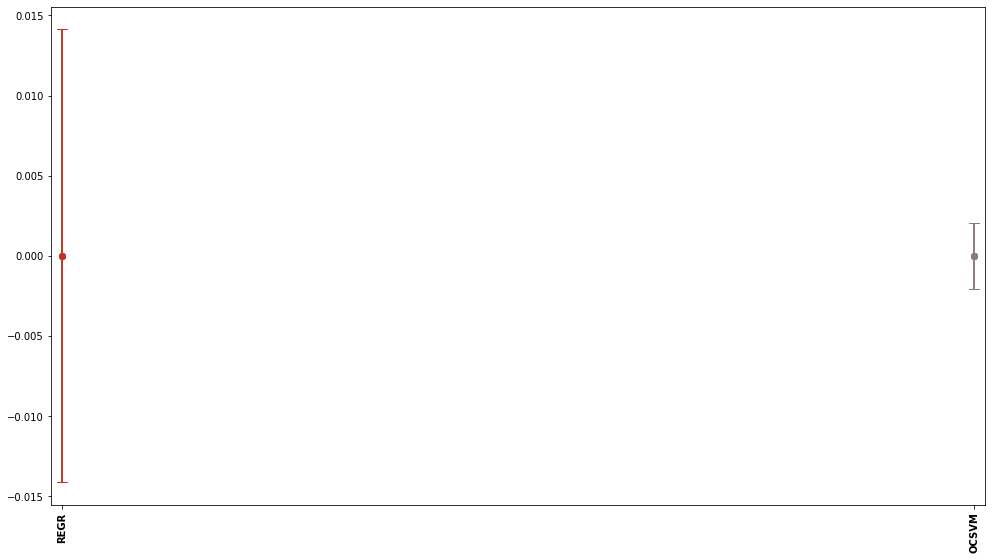

In [12]:
bench_plotter(df, random=True)

### 3. Time Complexity Benchmark

In [13]:
from pyod.utils.data import generate_data
import big_o # Make sure to install package


func = lambda n: n

times = []

# Define function to calculate big-O number
def threshold(size):

    contamination = 0.2  # percentage of outliers
    n_train = size  # number of training points
    n_test = 50  # number of testing points

    # Generate sample data
    X_train, X_test, y_train, y_test = \
        generate_data(n_train=n_train,
                          n_test=n_test,
                          n_features=2,
                          contamination=contamination,
                          random_state=9718)
    clf = PCA()
    clf.fit(X_train)

    y_train_scores = clf.decision_scores_ 

    thres = IQR()
    scores = thres.eval(y_train_scores)

# Note that some thresholders have high time complexity, typically ser repeats to 0 or 1 for them
best, others = big_o.big_o(threshold, func, min_n=100,
                           max_n=10000, n_repeats=5)

print(best)

Linearithmic: time = 0.033 + 2.9E-07*n*log(n) (sec)
